In [ ]:
# Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, find_peaks
import glob
import pandas as pd

In [ ]:
# For plotting pandas dataframes
def plot_df(df):
    # Plotting each column with row number as x-axis
    df.plot()

    # Adding labels and title
    plt.xlabel('Row Number')
    plt.ylabel('Values')
    plt.title('Pandas DataFrame Plot')
    plt.show()

def plot_ndarray(arr):
    plt.figure(figsize=(10, 5))
    plt.plot(arr, label='Values')
    plt.legend()
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation value')
    plt.show()

In [ ]:
# Global variables

# 2D Array, 137 features per row
all_features = np.empty((0, 137))
# 1D array, 1 number per row
all_answers = list()
# List of every file name in RawData
file_names = glob.glob("RawData" + '/*.txt')

In [ ]:
def full_autocorrelation(data):
    autocorr_x = np.correlate(data[0], data[0], mode='full')[len(data[0])-1:]
    autocorr_y = np.correlate(data[1], data[1], mode='full')[len(data[1])-1:]
    autocorr_z = np.correlate(data[2], data[2], mode='full')[len(data[2])-1:]
    return autocorr_x, autocorr_y, autocorr_z

In [124]:
def extractWindow(acc_data, gyro_data, activityNum: int):
    # Eventually a list of features 137 items long
    cur_features_row = np.array([])

    # Calculate mean for each direction in acc and gyro (6 total)
    mean_acc_x = acc_data[0].mean()
    mean_acc_y = acc_data[1].mean()
    mean_acc_z = acc_data[2].mean()
    mean_gyro_x = gyro_data[0].mean()
    mean_gyro_y = gyro_data[1].mean()
    mean_gyro_z = gyro_data[2].mean()

    # Calculate RMS for all (6 total numbers)
    rms_acc_x = np.sqrt(np.mean(acc_data[0]**2))
    rms_acc_y = np.sqrt(np.mean(acc_data[1]**2))
    rms_acc_z = np.sqrt(np.mean(acc_data[2]**2))
    rms_gyro_x = np.sqrt(np.mean(gyro_data[0]**2))
    rms_gyro_y = np.sqrt(np.mean(gyro_data[1]**2))
    rms_gyro_z = np.sqrt(np.mean(gyro_data[2]**2))

    '''I don't think I'm doing this right'''
    # Calculate autocorrelation for all. Height of 1st peak, height of 2nd peak, and position of 2nd peak (18 total numbers)
    acc_autocorr_x, acc_autocorr_y, acc_autocorr_z = full_autocorrelation(acc_data)
    gyro_autocorr_x, gyro_autocorr_y, gyro_autocorr_z = full_autocorrelation(gyro_data)

    #========================================================================================================


    mean_acc = np.mean(acc_data,axis=1)
    data =(mean_acc) + np.random.normal(0, 0.1, len(mean_acc))  # add noise
    data = (data - np.mean(data)) / np.std(data) #normalize data

    # Convert to a pandas Series
    composite_signal_series = pd.Series(data)

    # Calculate autocorrelation for different lags
    lags = range(-20, 21)  # Example range of lags from -5 to 5
    autocorr_values = [composite_signal_series.autocorr(lag=k) for k in lags]
    # Smooth the autocorrelation values using a moving average
    window_size = 5  # Size of the smoothing window
    smoothed_autocorr_values = np.convolve(autocorr_values, np.ones(window_size)/window_size, mode='valid')
    smoothed_lags = lags[(window_size-1)//2: -(window_size//2)]


    # Plotting the autocorrelation on the existing plot
    plt.plot(smoothed_lags, smoothed_autocorr_values, marker='o', label=activityNum)
#=================================================================================================================

    # plt.figure(figsize=(12, 6))
    # plt.plot(acc_autocorr_x, label='Acc X-axis')
    # plt.plot(acc_autocorr_y, label='Acc Y-axis')
    # plt.plot(acc_autocorr_z, label='Acc Z-axis')
    # plt.legend()
    # plt.title('Autocorrelation for Accelerometer Data')
    # plt.xlabel('Lag')
    # plt.ylabel('Autocorrelation value')
    # plt.show()

    # Spectral peaks (72)


    # Spectral power (30)


    # Resultant acceleration (1)


    # Resultant gyro (1)


    # Angle btwn resultant acc and each acc input (3)



    

    # all_features = np.vstack(all_features, cur_features_row)
    # all_answers.append(activityNum)


In [ ]:
'''These are for noise reduction'''
# Function to apply median filter
def apply_median_filter(data, window_size):
    return data.rolling(window=window_size, center=True, min_periods=1).median()

# Function to design a low-pass Butterworth filter
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply the Butterworth filter
def apply_low_butter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data, axis=0)
    return y

'''This is for getting body acc component from total acc'''
# Define a function to create a high-pass Butterworth filter
def butter_highpass(cutoff, fs, order):
    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Define a function to apply the high-pass filter to data
def apply_high_butter(data, cutoff, fs, order):
    b, a = butter_highpass(cutoff, fs, order)
    y = filtfilt(b, a, data, axis=0)
    return y

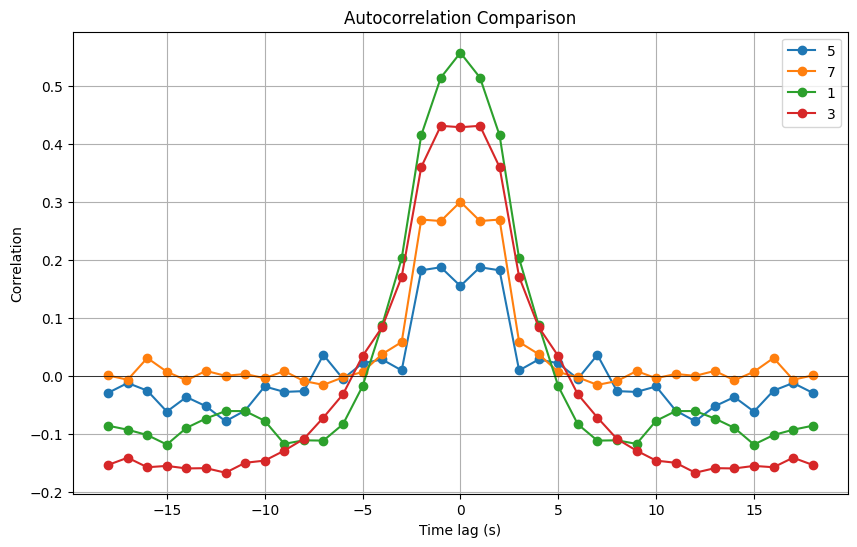

In [129]:
# For handling raw data
def extractAllFeatures(label: str):
    splitted = label.split()
    experimentNum, activityNum, start, end = int(splitted[0]), int(splitted[2]), int(splitted[3]), int(splitted[4])

    acc_file_name = file_names[experimentNum-1]
    gyro_file_name = file_names[experimentNum-1+61]

    # Reading acc and gyro in data for this label range
    acc_data = pd.read_csv(acc_file_name, sep=' ', header=None, skiprows=start, nrows=end-start)
    gyro_data = pd.read_csv(gyro_file_name, sep=' ', header=None, skiprows=start, nrows=end-start)

    ''' I'm not too sure how these filters work but I hope they do'''
    # Apply median filter to each axis of accelerometer and gyroscope data (for noise reduction)
    WINDOW_SIZE = 3
    acc_data_filtered = acc_data.apply(apply_median_filter, window_size=WINDOW_SIZE)
    gyro_data_filtered = gyro_data.apply(apply_median_filter, window_size=WINDOW_SIZE)
    
    # Apply low-pass Butterworth filter to each axis of accelerometer and gyroscope data (for noise reduction)
    FS = 50                     # Sampling frequency in Hz (you mentioned 50Hz)
    CUTOFF_LOW_PASS = 20        # Desired cutoff frequency of the filter, Hz
    ORDER = 3                   # Order of the Butterworth filter
    acc_data_filtered = acc_data_filtered.apply(lambda col: apply_low_butter(col, CUTOFF_LOW_PASS, FS, ORDER))
    gyro_data_filtered = gyro_data_filtered.apply(lambda col: apply_low_butter(col, CUTOFF_LOW_PASS, FS, ORDER))    

    # Apply high-pass Butterworth filter to acc to get body component
    CUTOFF_HIGH_PASS = 0.5
    acc_data_filtered = acc_data_filtered.apply(lambda col: apply_high_butter(col, CUTOFF_HIGH_PASS, FS, ORDER))

    # 2.5sec windows * 50 samples per sec = 125 samples per window
    # 50% overlap means we go up by 62 for every new window
    # end-62 is used to skip the last half window that gets added
    length = end-start
    i = 0
    # while i < length-62:
    #     trueEnd = min(i+125, length)
    #     extractWindow(acc_data_filtered[i: trueEnd], gyro_data_filtered[i: trueEnd], activityNum)
    #     i += 62
    trueEnd = min(i+125, length)
    extractWindow(acc_data_filtered[i: trueEnd], gyro_data_filtered[i: trueEnd], activityNum)

    

'''For testing'''

# extractAllFeatures('1 1 4 1393 2194')
# extractAllFeatures('1 1 1 7496 8078')
# extractAllFeatures('1 1 2 14069 14699')
# extractAllFeatures('1 1 3 14869 15492')

# Initialize the plot
plt.figure(figsize=(10, 6))
# Finalize the plot
extractAllFeatures('1 1 5 250 1232')
extractAllFeatures('1 1 7 1233 1392')
extractAllFeatures('1 1 1 7496 8078')
extractAllFeatures('1 1 3 14869 15492')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Autocorrelation Comparison')
plt.xlabel('Time lag (s)')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
# Main function
def main():
    # Grab the labels.txt file telling you what each data section means
    labels_file = open('labels.txt') 
    labels_list = labels_file.readlines()

    # For each section: 
        # i. Load that section's respective data
        # ii. For each window in that section:
            # a. Apply noise filters on the window
            # b. Compute features from the window
            # c. Store those feature values in an array
    for label in labels_list:
        extractAllFeatures(label)
    
    # Take all_features and answers, split into test and train, and finally write to .txt files

if __name__ == "__main__":
    main()